<a href="https://colab.research.google.com/github/pkodi333/GameStop-How-do-tweets-affect-the-Stock-Market-/blob/main/Gamestop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk as nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as stop
import pandas as pd
import numpy as np
import math
import re
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
import string

from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import vaderSentiment
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls


import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


***Reading the Data***

In [2]:
from google.colab import files
uploaded = files.upload()


Saving Tweets_cleaned_Apr21_Oct21.csv to Tweets_cleaned_Apr21_Oct21 (1).csv


In [3]:
import pandas as pd

df = pd.read_csv("Tweets_cleaned_Apr21_Oct21.csv")


In [4]:
df[:5]

,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-10-03 23:44:12+00:00,BREAKING NEWS! Get ahold of Gamestop stock sha...,BREAKING NEWS! Get ahold of Gamestop stock sha...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444810e+18,en,"<a href=""https://cheapbotsdonequick.com"" rel=""...",https://cheapbotsdonequick.com,"Cheap Bots, Done Quick!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,breaking news! get ahold of gamestop stock sha...,"['breaking', 'news!', 'get', 'ahold', 'of', 'g..."
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/CraigRowin/status/14448056...,2021-10-03 23:24:46+00:00,If I have to wait one more day for those GameS...,If I have to wait one more day for those GameS...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,7,0,1.444810e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,if i have to wait one more day for those games...,"['if', 'i', 'have', 'to', 'wait', 'one', 'more..."
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/theshadowking18/status/144...,2021-10-03 23:04:49+00:00,@MysticDistance *local politician likes gamest...,@MysticDistance *local politician likes gamest...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444800e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,"*local politician likes gamestop, gme stock so...","['*local', 'politician', 'likes', 'gamestop,',..."
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/KnightAziren/status/144479...,2021-10-03 22:54:15+00:00,@Becca_Sizemore @Fondle_Saurus oddly enough be...,@Becca_Sizemore @Fondle_Saurus oddly enough be...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,0,1.444290e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,oddly enough besides just amazon and ebay ... ...,"['oddly', 'enough', 'besides', 'just', 'amazon..."
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/PokemonTCGDrops/status/144...,2021-10-03 22:49:13+00:00,Eevee Tins back in stock at Gamestop \n\nThx @...,Eevee Tins back in stock at Gamestop \n\nThx @...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",11,11,50,1,1.444800e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,['https://www.gamestop.com/toys-games/trading-...,['https://t.co/sZfLJbfcAQ'],NaN,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,eevee tins back in stock at gamestop thx,"['eevee', 'tins', 'back', 'in', 'stock', 'at',..."


In [5]:
def clean_tweet(tweet):
    temp = tweet.lower()
    temp = re.sub(r"@[A-Za-z0-9_]+","", temp)
    temp = re.sub(r"#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    ###############Removing emojis###############
    emoj = re.compile("[" u"\U0001F600-\U0001F64F"  # emoticons
               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
               u"\U0001F680-\U0001F6FF"  # transport & map symbols
               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
               u"\U00002702-\U000027B0"
               u"\U000024C2-\U0001F251"
               u"\U0001f926-\U0001f937"
               u"\u200d"
               u"\u2640-\u2642" 
               "]+", flags=re.UNICODE)
    temp = re.sub(emoj, '', temp)
    temp = temp.split()
    return temp

###########################################################################
#Taking all the words and making a list
cleanup = []

for word in df['content']:
    cleanup.append(word)

#Cleaned up version of words in the list
cleaned_words = []
c = 0
while c < len(cleanup):
    cleaned_words.append(clean_tweet(cleanup[c]))
    c += 1
    
#Making a sentence out of cleaned words and putting clean sentence in a column
cleaned_sentence = []
d = 0
while d < len(cleaned_words):
    cleaned_sentence.append(' '.join(cleaned_words[d]))
    cleaned_sentence[d] = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|http\S+|^\s+|\s+$', '', cleaned_sentence[d])
    d += 1
    
df['cleaned_sentence'] = cleaned_sentence

#Check word counts
all_words = []
i = 0
j = 0

while i < len(cleaned_sentence):
    j = 0
    while j < len(cleaned_sentence[i].split()):
        all_words.append(cleaned_sentence[i].split()[j])
        j += 1
    i += 1
    
    
# Mapping words to the corresponding tweet in the dataframe
def to_word(x):
    return x.split()

df['words'] = df['cleaned_sentence'].map(to_word)
df.head()

,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-10-03 23:44:12+00:00,BREAKING NEWS! Get ahold of Gamestop stock sha...,BREAKING NEWS! Get ahold of Gamestop stock sha...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444810e+18,en,"<a href=""https://cheapbotsdonequick.com"" rel=""...",https://cheapbotsdonequick.com,"Cheap Bots, Done Quick!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,breaking news get ahold of gamestop stock shar...,"[breaking, news, get, ahold, of, gamestop, sto..."
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/CraigRowin/status/14448056...,2021-10-03 23:24:46+00:00,If I have to wait one more day for those GameS...,If I have to wait one more day for those GameS...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,7,0,1.444810e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,if i have to wait one more day for those games...,"[if, i, have, to, wait, one, more, day, for, t..."
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/theshadowking18/status/144...,2021-10-03 23:04:49+00:00,@MysticDistance *local politician likes gamest...,@MysticDistance *local politician likes gamest...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444800e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,"*local politician likes gamestop, gme stock so...","[*local, politician, likes, gamestop,, gme, st..."
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/KnightAziren/status/144479...,2021-10-03 22:54:15+00:00,@Becca_Sizemore @Fondle_Saurus oddly enough be...,@Becca_Sizemore @Fondle_Saurus oddly enough be...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,0,1.444290e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,oddly enough besides just amazon and ebay ... ...,"[oddly, enough, besides, just, amazon, and, eb..."
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/PokemonTCGDrops/status/144...,2021-10-03 22:49:13+00:00,Eevee Tins back in stock at Gamestop \n\nThx @...,Eevee Tins back in stock at Gamestop \n\nThx @...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",11,11,50,1,1.444800e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,['https://www.gamestop.com/toys-games/trading-...,['https://t.co/sZfLJbfcAQ'],NaN,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,eevee tins back in stock at gamestop thx,"[eevee, tins, back, in, stock, at, gamestop, thx]"


In [6]:
#This splits all the sentences up which makes it easier for us to work with
all_sentences = []

for word in df.cleaned_sentence:
    all_sentences.append(word)

all_sentences


lines = list()
for line in all_sentences:    
    words = line.split()
    for w in words: 
        lines.append(w)

df.head()

,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-10-03 23:44:12+00:00,BREAKING NEWS! Get ahold of Gamestop stock sha...,BREAKING NEWS! Get ahold of Gamestop stock sha...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444810e+18,en,"<a href=""https://cheapbotsdonequick.com"" rel=""...",https://cheapbotsdonequick.com,"Cheap Bots, Done Quick!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,breaking news get ahold of gamestop stock shar...,"[breaking, news, get, ahold, of, gamestop, sto..."
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/CraigRowin/status/14448056...,2021-10-03 23:24:46+00:00,If I have to wait one more day for those GameS...,If I have to wait one more day for those GameS...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,7,0,1.444810e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,if i have to wait one more day for those games...,"[if, i, have, to, wait, one, more, day, for, t..."
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/theshadowking18/status/144...,2021-10-03 23:04:49+00:00,@MysticDistance *local politician likes gamest...,@MysticDistance *local politician likes gamest...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444800e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,"*local politician likes gamestop, gme stock so...","[*local, politician, likes, gamestop,, gme, st..."
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/KnightAziren/status/144479...,2021-10-03 22:54:15+00:00,@Becca_Sizemore @Fondle_Saurus oddly enough be...,@Becca_Sizemore @Fondle_Saurus oddly enough be...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,0,1.444290e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,oddly enough besides just amazon and ebay ... ...,"[oddly, enough, besides, just, amazon, and, eb..."
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/PokemonTCGDrops/status/144...,2021-10-03 22:49:13+00:00,Eevee Tins back in stock at Gamestop \n\nThx @...,Eevee Tins back in stock at Gamestop \n\nThx @...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",11,11,50,1,1.444800e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,['https://www.gamestop.com/toys-games/trading-...,['https://t.co/sZfLJbfcAQ'],NaN,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,eevee tins back in stock at gamestop thx,"[eevee, tins, back, in, stock, at, gamestop, thx]"


In [8]:
#Removing Punctuation
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

#Lemmatization
lemmatizer = WordNetLemmatizer()
lemma = []
for word in lines2:
    lemma.append(lemmatizer.lemmatize(word))

#Removing stopwords from lemmatized words  (list of words)
import nltk
nltk.download('stopwords')
stop_words=set(stop.words("english"))
lemma2 = []
for word in lemma:
    if word not in stop_words:
        lemma2.append(word)
        
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-10-03 23:44:12+00:00,BREAKING NEWS! Get ahold of Gamestop stock sha...,BREAKING NEWS! Get ahold of Gamestop stock sha...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444810e+18,en,"<a href=""https://cheapbotsdonequick.com"" rel=""...",https://cheapbotsdonequick.com,"Cheap Bots, Done Quick!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,breaking news get ahold of gamestop stock shar...,"[breaking, news, get, ahold, of, gamestop, sto..."
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/CraigRowin/status/14448056...,2021-10-03 23:24:46+00:00,If I have to wait one more day for those GameS...,If I have to wait one more day for those GameS...,1.444810e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,7,0,1.444810e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,if i have to wait one more day for those games...,"[if, i, have, to, wait, one, more, day, for, t..."
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/theshadowking18/status/144...,2021-10-03 23:04:49+00:00,@MysticDistance *local politician likes gamest...,@MysticDistance *local politician likes gamest...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.444800e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,"*local politician likes gamestop, gme stock so...","[*local, politician, likes, gamestop,, gme, st..."
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/KnightAziren/status/144479...,2021-10-03 22:54:15+00:00,@Becca_Sizemore @Fondle_Saurus oddly enough be...,@Becca_Sizemore @Fondle_Saurus oddly enough be...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,0,1.444290e+18,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,oddly enough besides just amazon and ebay ... ...,"[oddly, enough, besides, just, amazon, and, eb..."
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/PokemonTCGDrops/status/144...,2021-10-03 22:49:13+00:00,Eevee Tins back in stock at Gamestop \n\nThx @...,Eevee Tins back in stock at Gamestop \n\nThx @...,1.444800e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",11,11,50,1,1.444800e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,['https://www.gamestop.com/toys-games/trading-...,['https://t.co/sZfLJbfcAQ'],NaN,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,eevee tins back in stock at gamestop thx,"[eevee, tins, back, in, stock, at, gamestop, thx]"


In [9]:
#Removing Collection words from lemmatized words
collection_words = ['gamestop','gamestops', 'gme', 'game','dont', 'still', 'like', 'wa', 'get', 'got', 'im', 'no', 'go', '2', 
                    'ha', 'said', 'one', 'know', 'lol', 'going', 'u', 'say', 'hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 
                    'im', 'want', 'like', '$', '@', 'mine', 'ps5', 'xbox', 'would', 'thats', 'even', 'back', 'x', 'ps5s', 
                    'de', 'via', 'see', 'edt', 'v2', 'pm', 'went', 'que', 'new', 'en', 'el']
for word in list(lemma2):  # iterating on a copy since removing will mess things up
    if word in collection_words:
        lemma2.remove(word)

#Renaming for making code easier to read        
word_corpus=lemma2

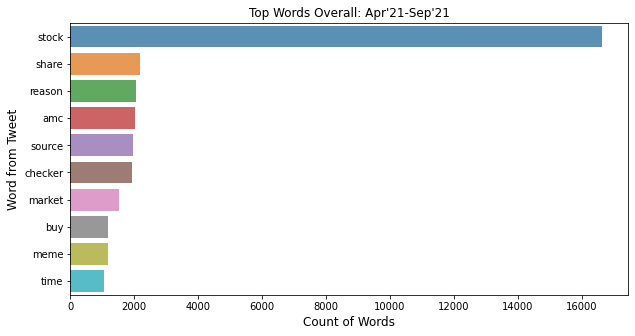

In [10]:
df_words = pd.DataFrame(word_corpus, columns = ['Words'])
df_words_vc = df_words['Words'].value_counts()

df_words_vc_top = df_words_vc[:10,]
plt.figure(figsize=(10,5))
sns.barplot(df_words_vc_top.values, df_words_vc_top.index, alpha=0.8)
plt.title("Top Words Overall: Apr'21-Sep'21")
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [11]:
#Showing entities being spoken in the text
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))

In [12]:
nlp.max_length = 3000000 # or even higher
str1 = " " 
lemma3 = str1.join(lemma2)
word_corpus_sentence = nlp(lemma3) #Words joined by space for the whole cleaned tweets

label = [(X.text, X.label_) for X in word_corpus_sentence.ents]

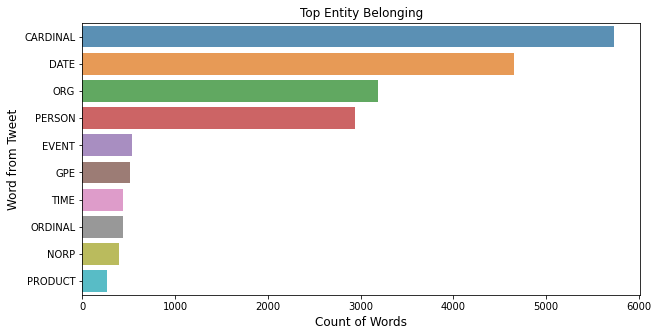

In [13]:
df_entity = pd.DataFrame(label, columns = ['Word','Entity'])
df_entity_vc = df_entity['Entity'].value_counts()

df_entity_vc_top10 = df_entity_vc[:10,]
plt.figure(figsize=(10,5))
sns.barplot(df_entity_vc_top10.values, df_entity_vc_top10.index, alpha=0.8)
plt.title('Top Entity Belonging')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

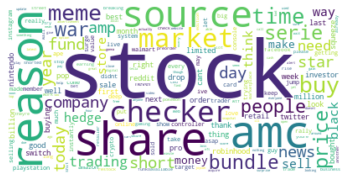

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(word_corpus_sentence))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

***Topic Modeling***

In [15]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','&amp;', ' ', '.', '-', 'got', "i'm", 'im', 'want', 'like','$','dont', 'still', 'like', 'wa', 'get', 
                    'got', 'im', 'no', 'go', '2','ha', 'said', 'one', 'know', 'lol', 'going', 'u', 'say', 'mine', 'ps5', 'xbox', 
                    'would', 'thats', 'even', 'back','gamestop','gamestops', 'gme', 'game','\n','\n\n', '&amp;', ' ', '.', '-', 
                    "it's",'im', 'want', 'like', '$', '@', 'x', 'ps5s','de', 'via', 'see', 'edt', 'v2', 'pm', 'went', 
                    'que', 'new', 'en', 'el']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['cleaned_sentence'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [16]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

In [17]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) 
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') 
    tokens = tokens.strip('?') 
    tokens = tokens.strip('!') 
    tokens = tokens.strip("'") 
    tokens = tokens.strip(".") 

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

In [18]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))


# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

17488
8549
------ Topic 0 ------
stock amc short gme meme day people money squeeze gamestop

------ Topic 1 ------
stock gamestop time market look sell try thank order buy

------ Topic 2 ------
stock share reason source checker star sell buy gamestop war

------ Topic 3 ------
stock reason source checker series meme price 5 playstation bundle

------ Topic 4 ------
stock gme market buy amc gamestop good meme short share



In [19]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.273246083463144

Coherence Score:  0.2674749884033399


In [20]:
df['date'] = df['date'].astype('datetime64[ns]')
df_sept = df.loc[(df['date'] >= '2021-09-01') & (df['date'] < '2021-09-30')]

In [21]:
analyzer= SentimentIntensityAnalyzer()

#Add VADER metrics to dataframe
df_sept['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_sept['cleaned_sentence']]
df_sept['negative'] = [analyzer.polarity_scores(v)['neg'] for v in df_sept['cleaned_sentence']]
df_sept['neutral'] = [analyzer.polarity_scores(v)['neu'] for v in df_sept['cleaned_sentence']]
df_sept['positive'] = [analyzer.polarity_scores(v)['pos'] for v in df_sept['cleaned_sentence']]
df_sept.head(3)

,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,compound,negative,neutral,positive
321,321,snscrape.modules.twitter.Tweet,https://twitter.com/ARS2117/status/14433632685...,2021-09-29 23:53:14,@D21Beast Yeah I seen it was in stock at GameS...,@D21Beast Yeah I seen it was in stock at GameS...,1.443360e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,0,1.443330e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.440000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,yeah i seen it was in stock at gamestop a coup...,"[yeah, i, seen, it, was, in, stock, at, gamest...","[yeah, seen, stock, couple, days, ago, bought,...",yeah seen stock couple days ago bought says wa...,"[yeah, see, stock, couple, day, ago, buy, say,...",yeah see stock couple day ago buy say wait pro...,"[yeah, see, stock, couple, day, ago, buy, say,...",-0.0772,0.052,0.882,0.066
322,322,snscrape.modules.twitter.Tweet,https://twitter.com/SteamFocus/status/14433625...,2021-09-29 23:50:23,PS5 Restock Update: GameStop Has PS5 Bundles F...,PS5 Restock Update: GameStop Has PS5 Bundles F...,1.443360e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,0,1.443360e+18,en,"<a href=""https://socialbee.io/"" rel=""nofollow""...",https://socialbee.io/,SocialBee.io v2,"['https://sbee.link/pgwjyqbt79', 'https://www....","['https://t.co/yLZOtElv6z', 'https://t.co/THTn...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['PS4', 'Xbox', 'Streamer']",NaN,ps5 restock update: gamestop has ps5 bundles f...,"[ps5, restock, update:, gamestop, has, ps5, bu...","[restock, update:, bundles, pro, members, stoc...",restock update: bundles pro members stock game...,"[restock, update, bundle, pro, members, stock,...",restock update bundle pro members stock gamesp...,"[restock, update, bundle, pro, members, stock,...",0.3612,0.000,0.937,0.063
323,323,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-09-29 23:14:36,NO WAY!? Acquire Gamestop stock shares on INST...,NO WAY!? Acquire Gamestop stock shares on INST...,1.443350e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1.443350e+18,en,"<a href=""https://cheapbotsdonequick.com"" rel=""...",https://cheapbotsdonequick.com,"Cheap Bots, Done Quick!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no way acquire gamestop stock shares on instag...,"[no, way, acquire, gamestop, stock, shares, on...","[way, acquire, stock, shares, instagram, limit...",way acquire stock shares instagram limited time,"[way, acquire, stock, share, instagram, limite...",way acquire stock share instagram limited time,"[way, acquire, stock, share, instagram, limite...",-0.2263,0.287,0.559,0.154


In [22]:
def sentiment_type(compound):
    if compound > 0:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_sept['sentiment'] = df_sept['compound'].apply(sentiment_type)
df_sept['date'] = pd.to_datetime(df_sept['date']).dt.date

df_positive = df_sept.loc[df_sept['sentiment'] == 'Positive']

df_summary = pd.DataFrame(df_positive.groupby(['date','sentiment'])['sentiment'].count())
df_summary

,,sentiment
date,sentiment,
2021-09-01,Positive,52
2021-09-02,Positive,49
2021-09-03,Positive,31
2021-09-04,Positive,27
2021-09-05,Positive,23
2021-09-06,Positive,27
2021-09-07,Positive,33
2021-09-08,Positive,90
2021-09-09,Positive,120
